In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

 >> Context(max_t=3.0, dt=0.1, n_instances=30, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

In [9]:
def gen_xy_sin_to_f(n_samples=500, n_t=1000, f=None, dt=0.01):
    # x_train = array (unique_samples, xs_over_t, sin(xs))
    # y_train = array (unique_samples, xs_over_t, sin(xs + dx))
    max_t = n_t * dt
    min_f = utils.min_f(max_t)
    max_f = utils.max_f(dt)
    print('allowed min max f', min_f, max_f)
    min_f = 5
    max_f = 5
    if f is None:
        fs = np.random.random(n_samples) * (max_f - min_f) + min_f
    else:
        fs = np.repeat(f, n_samples)
        
    phases = np.random.random(n_samples) * 2*np.pi
    timesteps = np.arange(n_t) * dt
    x_train = []
    y_train = []    
    for i, phase in enumerate(phases):
        # x: beginning of cycle
        f = fs[i]
        d_phase = n_t * dt * f
        data = sin_(n_t, f, phase)
        x_train.append(sin_(n_t, f, phase))
        # y: continuation of cycle        
        y_train.append(sin_(n_t, f, phase + d_phase))
    
    x_train = np.stack(x_train)
    x_train = x_train.reshape(n_samples, n_t, 1) 
    y_train = np.stack(y_train)
    y_train = y_train.reshape(n_samples, n_t, 1)
    return x_train, y_train
    
def sin_(n, f, phase=0, dt=0.01):
    ts = np.arange(n) * dt
    return (np.sin(2*np.pi * f * ts + phase * 2 * np.pi) + 1) * 0.5

In [10]:
n = 2
f = None
# f = 3
dt = 0.01
x_train, y_train = gen_xy_sin_to_f(n, f=f, dt=dt)
x_test, y_test = gen_xy_sin_to_f(10, f=f, dt=dt)
print(x_train.shape, y_train.shape)

allowed min max f 0.1 50.0
allowed min max f 0.1 50.0
(2, 1000, 1) (2, 1000, 1)


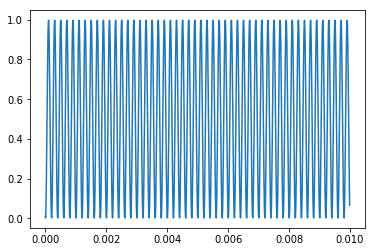

In [11]:
n4 = x_train.shape[1]
plt.plot(np.arange(n4) / n4 * dt, x_train[0])

In [12]:
# plt.plot(np.arange(n4) / n4 * dt, y_train[0])

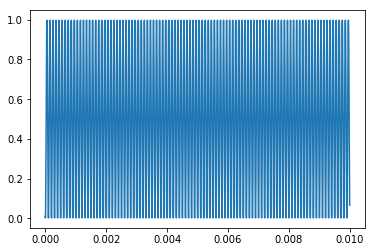

In [13]:
full = np.concatenate([x_train[0],y_train[0]])
n5 = full.shape[0]
plt.plot(np.arange(n5) / n5 * dt, full)

In [14]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train[0].shape # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 10
input_shape

(1000, 1)

In [15]:
output_shape

(1000, 1)

In [220]:
def encoder(input_shape, output_shape):
#     input_layer = Input(shape=input_shape)
    # input shape = (None, None, 1)
    # thus: unfixed n samples, unfixed n timesteps, 1 float value
    input_layer = Input(shape=(None,1))
    x = input_layer
    
    hidden_size = 128
#     xs = LSTM(hidden_size, return_state=True)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(hidden_size, return_state=False, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    
    w = np.prod(output_shape)
    print('w =',w)
    w = 10
    
    x = Dense(np.prod(output_shape), activation='sigmoid')(x)
    x = Reshape(output_shape)(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

encoder = encoder(input_shape, output_shape)
encoder.summary()

w = 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, None, 1)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, None, 64)          16896     
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
_________________________________________________________________
reshape_13 (Reshape)         (None, 1)                 0         
Tota

In [221]:
metrics = ['accuracy','mse','binary_crossentropy'] # sparse_categorical_accuracy
loss = 'mse'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'adadelta'
encoder.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae'])#, metrics=metrics)

In [222]:
batch_size = 1
# n epochs = n iterations over all the training data
epochs = 1

In [223]:
# decoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
encoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 8 samples, validate on 2 samples
Epoch 1/1
8/8 [==============================] - 10s 1s/step - loss: 0.1233 - mean_squared_error: 0.1233 - mean_absolute_error: 0.2995 - val_loss: 0.2198 - val_mean_squared_error: 0.2198 - val_mean_absolute_error: 0.4667


In [196]:
model = encoder
x_test.shape

(10, 999, 1)

In [197]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [198]:
results = model.predict(x_test)
results.shape

(10, 1)

In [199]:
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

ValueError: all the input arrays must have same number of dimensions

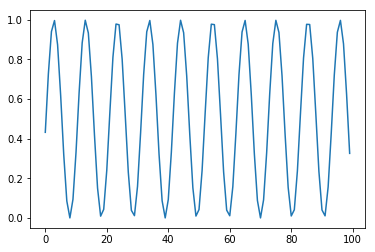

In [224]:
i = 0
# full = np.concatenate([x_test[i,-selection:],results[i]])
# n3 = full.shape[0]
plt.plot(x_test[0,-100:])

In [225]:
x = x_test[0]
for _ in range(100):
    print('i')
    results = model.predict(np.stack([x[-100:]]))
    last_value = results[:0]
    x = np.concatenate([x,last_value])

i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i


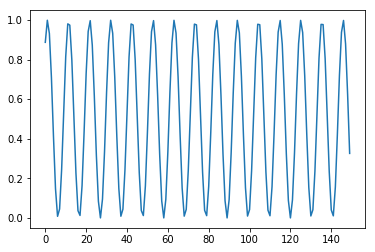

In [228]:
plt.plot(x[-150:])

In [203]:
a = np.arange(8).reshape(4,2)
a.shape

(4, 2)

In [ ]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [ ]:
results = predict_point_by_point(encoder, x_train)
plt.plot(results[0])